In [1]:
%matplotlib inline

import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from vrep_robot.robot import Robot

robot = Robot()

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Left motor connected.
 Right motor connected.
 Robot connected.


In [3]:
import vrep

def reset(robot):
    robot.command = ""
    robot.stop()
    res = vrep.simxStopSimulation(robot.clientID, vrep.simx_opmode_oneshot_wait)
    if res == vrep.simx_return_ok:
        print("Simulation stopped...")
        time.sleep(1.0)
    n = 0
    while True:
        n += 1
        res = vrep.simxStartSimulation(robot.clientID, vrep.simx_opmode_oneshot_wait)
        if res == vrep.simx_return_ok:
            print("Simulation started...")
            break
        time.sleep(1.0)
        if n == 10:
            print("Failed to start simulation!")
            break
        print(f"Retry {n}")

reset(robot)

Simulation stopped...
Simulation started...


**Reading ultrasonic sensors**

In [4]:
help(Robot.read_ultrassonic_sensors)

Help on function read_ultrassonic_sensors in module vrep_robot.robot:

read_ultrassonic_sensors(self)
    Reads the distances from the 16 ultrassonic sensors.
    Returns:
            distances: List with the distances in meters.



In [5]:
ultrasonic = robot.read_ultrassonic_sensors()
print("Ultrasonic :", ultrasonic)

Ultrasonic : [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 0.5884585976600647, 0.4596508741378784, 0.4456547796726227, 5.0, 5.0, 5.0, 5.0]


In [6]:
len(ultrasonic)

16

In [7]:
type(ultrasonic[0])

float

**Reading laser sensor**

In [8]:
help(Robot.read_laser)

Help on function read_laser in module vrep_robot.robot:

read_laser(self)
    Gets the 572 points read by the laser sensor. Each reading contains 3 values (x, y, z) of the point relative to the sensor position.
    Returns:
            laser: List with 1716 values of x, y and z from each point.



In [9]:
laser = robot.read_laser()
print("Laser (10) :", laser[:30])

Laser (10) : [-2.414750576019287, -4.182470798492432, 0.06300001591444016, -2.382589340209961, -4.185929775238037, 0.06300001591444016, -2.350986957550049, -4.190062522888184, 0.06300001591444016, -2.3106679916381836, -4.178131103515625, 0.06300000846385956, -2.2801647186279297, -4.183441162109375, 0.06300000846385956, -2.250189781188965, -4.189476013183594, 0.06300000846385956, -2.2115705013275146, -4.178945064544678, 0.06300000846385956, -2.1825220584869385, -4.1860432624816895, 0.06300000846385956, -2.1450273990631104, -4.1765031814575195, 0.06300000101327896, -2.1168618202209473, -4.184709548950195, 0.06300000101327896]


In [10]:
len(laser)

1239

In [11]:
len(laser) // 3

413

In [12]:
type(laser[0])

float

**Reading camera**

In [13]:
help(Robot.read_vision_sensor)

Help on function read_vision_sensor in module vrep_robot.robot:

read_vision_sensor(self)
    Reads the image raw data from vrep vision sensor.
    Returns:
            resolution: Tuple with the image resolution.
            image: List with the image data.



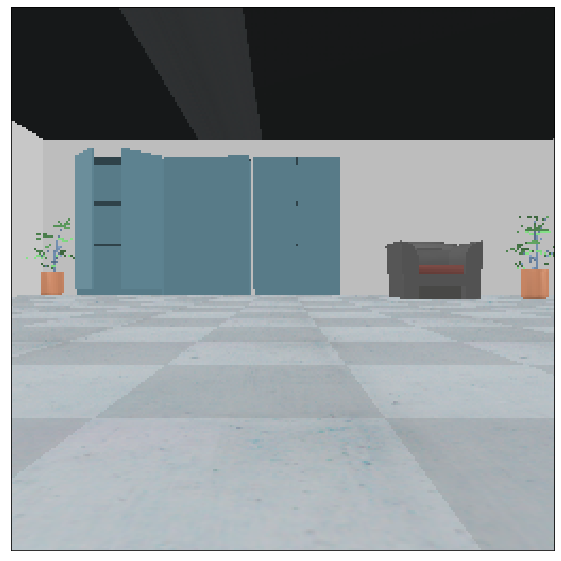

In [14]:
from vrep_robot.utils import vrep2array

resolution, raw_img = robot.read_vision_sensor()
img = vrep2array(raw_img, resolution)

plt.figure(figsize=(20,10))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

**Position and Locomotion**

In [15]:
help(Robot.get_current_position)

Help on function get_current_position in module vrep_robot.robot:

get_current_position(self)
    Gives the current robot position on the environment.
    Returns:
            position: Array with the (x,y,z) coordinates.



In [16]:
position = robot.get_current_position()

position

[-2.0253398418426514, -0.824985682964325, 0.13867820799350739]

In [17]:
help(Robot.get_current_orientation)

Help on function get_current_orientation in module vrep_robot.robot:

get_current_orientation(self)
    Gives the current robot orientation on the environment.
    Returns:
            orientation: Array with the euler angles (alpha, beta and gamma).



In [18]:
orientation = robot.get_current_orientation()

orientation

[-8.050590986385942e-05, -0.001988953910768032, -2.449028761475347e-05]

In [19]:
help(Robot.set_right_velocity)
help(Robot.set_left_velocity)
help(Robot.set_velocity)

Help on function set_right_velocity in module vrep_robot.robot:

set_right_velocity(self, vel)
    Sets the velocity on the right motor.
    Args:
            vel: The velocity to be applied in the motor (rad/s)

Help on function set_left_velocity in module vrep_robot.robot:

set_left_velocity(self, vel)
    Sets the velocity on the left motor.
    Args:
            vel: The velocity to be applied in the motor (rad/s)

Help on function set_velocity in module vrep_robot.robot:

set_velocity(self, V, W)
    Sets a linear and a angular velocity on the robot.
    Args:
            V: Linear velocity (m/s) to be applied on the robot along its longitudinal axis.
            W: Angular velocity (rad/s) to be applied on the robot along its axis of rotation, positive in the counter-clockwise direction.



**Simulation Tuning**

Custom settings.

* Time step = 250ms
* Real-time simulation enabled (w/ 'try catching up')

This settings work better to sync theoretical time and simulation time.

In [20]:
R = robot.WHEEL_RADIUS

R

0.0975

In [21]:
L = robot.ROBOT_WIDTH / 2

L

0.1905

...

*Translation Analysis*

Evaluate the fidelity of the simulation related to expected results from kinematic model.

The case is to move the robot in a straight line for 5 meters in the expected time.

In [22]:
s = 5.0 # meters
w = 1.0 # rads per second

T = s / (w * R) # seconds

T

51.28205128205128

In [23]:
reset(robot)

a = np.array(robot.get_current_position())
t0 = time.time()

robot.set_right_velocity(w)
robot.set_left_velocity(w)
time.sleep(T)

t1 = time.time()

b = np.array(robot.get_current_position())
D = np.linalg.norm(a-b)

robot.stop()
time.sleep(0.5)

c = np.array(robot.get_current_position())
D_ = np.linalg.norm(b-c)

print("Position Initial  :", a)
print("Position Final    :", b)
print("Position Stop     :", c)
print("Distance Expected :", s)
print("Distance Actual   :", D)
print("Distance Stop     :", D_)
print("Time Expected     :", T)
print("Time Actual       :", t1 - t0)

Simulation stopped...
Simulation started...
Position Initial  : [-2.02499795 -0.82499862  0.13879307]
Position Final    : [ 2.94288278 -0.82585227  0.13870265]
Position Stop     : [ 2.97055507 -0.82588017  0.13870418]
Distance Expected : 5.0
Distance Actual   : 4.967880800027767
Distance Stop     : 0.027672304904286415
Time Expected     : 51.28205128205128
Time Actual       : 51.33144497871399


In [24]:
reset(robot)

a = np.array(robot.get_current_position())
t0 = time.time()

robot.set_right_velocity(w)
robot.set_left_velocity(w)

while True:
    time.sleep(1)
    b = np.array(robot.get_current_position())
    D = np.linalg.norm(a-b)
    if D >= s:
        break

t1 = time.time()

robot.stop()
time.sleep(0.5)

c = np.array(robot.get_current_position())
D_ = np.linalg.norm(b-c)

print("Position Initial  :", a)
print("Position Final    :", b)
print("Position Stop     :", c)
print("Distance Expected :", s)
print("Distance Actual   :", D)
print("Distance Stop     :", D_)
print("Time Expected     :", T)
print("Time Actual       :", t1 - t0)

Simulation stopped...
Simulation started...
Position Initial  : [-2.02499795 -0.82499862  0.13879307]
Position Final    : [ 3.01598692 -0.8258872   0.13870268]
Position Stop     : [ 3.043643   -0.82591552  0.13870582]
Distance Expected : 5.0
Distance Actual   : 5.040984948130252
Distance Stop     : 0.02765609300929411
Time Expected     : 51.28205128205128
Time Actual       : 52.05220985412598


...

*Rotation Analysis*

Evaluate the fidelity of the simulation related to expected results from kinematic model.

The case is to turn the robot by 90° in the expected time.

In [25]:
rot = 90 * np.pi / 180 # rads
w = 0.1 # rads per second

T = (rot * L) / (w * R) # seconds

T

30.69094361583874

In [26]:
reset(robot)

a = robot.get_current_orientation()[2]
t0 = time.time()

#robot.set_velocity(0, -w * R / L)
robot.set_right_velocity(w)
robot.set_left_velocity(-w)
time.sleep(T)
robot.stop()

t1 = time.time()

time.sleep(0.5)

b = robot.get_current_orientation()[2]

if a >= 0 and b < 0:
    D = 2 * np.pi + b - a 
else:
    D = abs(b - a)
    
print("Gamma Initial :", a)
print("Gamma Final   :", b)
print("Rot Expected  :", rot)
print("Rot Actual    :", D)
print("Time Expected :", T)
print("Time Actual   :", t1 - t0)

Simulation stopped...
Simulation started...
Gamma Initial : -0.0
Gamma Final   : 1.7953742742538452
Rot Expected  : 1.5707963267948966
Rot Actual    : 1.7953742742538452
Time Expected : 30.69094361583874
Time Actual   : 30.820745706558228


In [27]:
reset(robot)

a = robot.get_current_orientation()[2]
t0 = time.time()

#robot.set_velocity(0, -w * R / L)
robot.set_right_velocity(w)
robot.set_left_velocity(-w)

while True:
    time.sleep(0.1)
    b = robot.get_current_orientation()[2]

    if a >= 0 and b < 0:
        D = 2 * np.pi + b - a 
    else:
        D = abs(b - a)
    if D >= rot:
        break

robot.stop()

t1 = time.time()

#time.sleep(0.5)

print("Gamma Initial :", a)
print("Gamma Final   :", b)
print("Rot Expected  :", rot)
print("Rot Actual    :", D)
print("Time Expected :", T)
print("Time Actual   :", t1 - t0)

Simulation stopped...
Simulation started...
Gamma Initial : -0.0
Gamma Final   : 1.5808075666427612
Rot Expected  : 1.5707963267948966
Rot Actual    : 1.5808075666427612
Time Expected : 30.69094361583874
Time Actual   : 27.355641841888428


## Data Collection

In [28]:
reset(robot)

def read_data(robot):
    timestamp = time.time()
    command = getattr(robot, "command", "")
    position = robot.get_current_position()
    orientation = robot.get_current_orientation()
    ultrasonic = robot.read_ultrassonic_sensors()
    laser = robot.read_laser()
    
    return [
        timestamp,    # 1 column
        command,      # 1 column
        *position,    # 3 columns
        *orientation, # 3 columns
        *ultrasonic,  # 16 columns
        *laser,       # 1239 columns (not always)
    ]

data = read_data(robot)

len(data)

Simulation stopped...
Simulation started...


1263

In [29]:
def move(robot, distance, angular_velocity=1.0, verbose=True):
    if verbose:
        direction = "forward" if angular_velocity > 0 else "backward"
        print(f"Moving {direction} {distance}m at {abs(angular_velocity)}rad/s")
    robot.command = f"move {distance} {angular_velocity}"
    T = distance / (abs(angular_velocity) * robot.WHEEL_RADIUS)
    robot.set_right_velocity(angular_velocity)
    robot.set_left_velocity(angular_velocity)
    time.sleep(T)
    robot.stop()
    time.sleep(0.5)
    robot.command = ""

def rotate(robot, angle=90, angular_velocity=0.1, verbose=True):
    if verbose:
        direction = "left" if angle * angular_velocity > 0 else "right"
        print(f"Rotating {direction} {abs(angle)}° at {abs(angular_velocity)}rad/s")
    robot.command = f"rotate {angle} {angular_velocity}"
    angle = angle * np.pi / 180 # rads
    distance = abs(angle) * robot.ROBOT_WIDTH / 2
    T = distance / (abs(angular_velocity) * robot.WHEEL_RADIUS)
    if angle < 0:
        angular_velocity = -angular_velocity
    robot.set_right_velocity(angular_velocity)
    robot.set_left_velocity(-angular_velocity)
    time.sleep(T - 0.2) # reduce overshoot
    robot.stop()
    time.sleep(0.5)
    robot.command = ""

robot.stop()
move(robot, 1.0)
rotate(robot, -90)
move(robot, 2.0)
rotate(robot, 90)
move(robot, 4.0)
rotate(robot, 90)
move(robot, 4.0)
rotate(robot, 90)
move(robot, 4.0)
rotate(robot, 90)
move(robot, 2.0)
rotate(robot, 90)

Moving forward 1.0m at 1.0rad/s
Rotating right 90° at 0.1rad/s
Moving forward 2.0m at 1.0rad/s
Rotating left 90° at 0.1rad/s
Moving forward 4.0m at 1.0rad/s
Rotating left 90° at 0.1rad/s
Moving forward 4.0m at 1.0rad/s
Rotating left 90° at 0.1rad/s
Moving forward 4.0m at 1.0rad/s
Rotating left 90° at 0.1rad/s
Moving forward 2.0m at 1.0rad/s
Rotating left 90° at 0.1rad/s


In [30]:
import threading

class DataCollector(threading.Thread):
    def __init__(self, robot, read_interval=0.5):
        threading.Thread.__init__(self)
        self.robot = robot
        self.read_interval = read_interval
        self.terminate = False
        self.data = list()

    def stop(self):
        self.terminate = True
    
    def run(self):
        self.terminate = False
        self.data = list()
        N = int(60 / self.read_interval)
        while not self.terminate:
            n = len(self.data) + 1
            if n % N == 0:
                print(f"Collecting data {n}...")
            data = read_data(self.robot)
            self.data.append(data)
            time.sleep(self.read_interval)

dc = DataCollector(robot)

dc.start()

time.sleep(10)

dc.stop()

len(dc.data)

20

In [31]:
class Explore(threading.Thread):
    def __init__(self, robot):
        threading.Thread.__init__(self)
        self.robot = robot

    def run(self):
        robot = self.robot
        robot.stop()
        print("Start.")
        move(robot, 1.0)
        rotate(robot, -90)
        move(robot, 2.0)
        rotate(robot, 90)
        move(robot, 4.0)
        rotate(robot, 90)
        move(robot, 4.0)
        rotate(robot, 90)
        move(robot, 4.0)
        rotate(robot, 90)
        move(robot, 2.0)
        rotate(robot, 90)
        print("Done.")

reset(robot)
x = Explore(robot)
x.start()
x.join()

Simulation stopped...
Simulation started...
Start.
Moving forward 1.0m at 1.0rad/s
Rotating right 90° at 0.1rad/s
Moving forward 2.0m at 1.0rad/s
Rotating left 90° at 0.1rad/s
Moving forward 4.0m at 1.0rad/s
Rotating left 90° at 0.1rad/s
Moving forward 4.0m at 1.0rad/s
Rotating left 90° at 0.1rad/s
Moving forward 4.0m at 1.0rad/s
Rotating left 90° at 0.1rad/s
Moving forward 2.0m at 1.0rad/s
Rotating left 90° at 0.1rad/s
Done.


In [32]:
reset(robot)

dc = DataCollector(robot)
dc.start()

x = Explore(robot)
x.start()

x.join()
time.sleep(2)
dc.stop()

len(dc.data)

Simulation stopped...
Simulation started...
Start.
Moving forward 1.0m at 1.0rad/s
Rotating right 90° at 0.1rad/s
Moving forward 2.0m at 1.0rad/s
Rotating left 90° at 0.1rad/s
Moving forward 4.0m at 1.0rad/s
Rotating left 90° at 0.1rad/s
Moving forward 4.0m at 1.0rad/s
Rotating left 90° at 0.1rad/s
Moving forward 4.0m at 1.0rad/s
Rotating left 90° at 0.1rad/s
Moving forward 2.0m at 1.0rad/s
Rotating left 90° at 0.1rad/s
Done.


726

In [33]:
llen = None
i = 0
n = 0
for i_, data in enumerate(dc.data):
    llen_ = len(data)
    if llen is None:
        llen = llen_
        n = 1
    elif llen != llen_:
        print(llen, i, n)
        llen = llen_
        i = i_
        n = 1
    else:
        n += 1

1275 0 1
1266 1 1
1260 2 3
1263 5 1
1269 6 1
1275 7 1
1281 8 1
1275 9 1
1281 10 3
1299 13 1
1296 14 2
1302 16 1
1290 17 1
1302 18 1
1299 19 1
1305 20 1
1299 21 1
1290 22 1
1284 23 1
1287 24 1
1302 25 1
1299 26 1
1284 27 1
1269 28 1
1257 29 2
1239 31 1
1218 32 1
1221 33 1
1212 34 1
1203 35 2
1200 37 1
1212 38 1
1206 39 1
1212 40 1
1209 41 2
1212 43 2
1206 45 3
1218 48 1
1206 49 1
1200 50 1
1194 51 1
1212 52 1
1200 53 1
1185 54 1
1167 55 1
1170 56 1
1149 57 1
1140 58 1
1113 59 1
1110 60 1
1083 61 1
1074 62 1
1077 63 1
1074 64 1
1080 65 1
1071 66 1
1083 67 1
1074 68 1
1083 69 1
1080 70 1
1071 71 1
1068 72 1
1089 73 1
1083 74 1
1080 75 1
1107 76 1
1128 77 1
1149 78 1
1164 79 1
1167 80 1
1170 81 1
1173 82 2
1191 84 1
1200 85 1
1185 86 1
1212 87 1
1224 88 1
1230 89 1
1248 90 1
1263 91 1
1269 92 1
1290 93 1
1305 94 1
1317 95 1
1332 96 1
1347 97 1
1362 98 1
1392 99 1
1404 100 1
1407 101 1
1431 102 1
1434 103 1
1443 104 1
1464 105 1
1482 106 1
1479 107 1
1494 108 1
1518 109 1
1548 110 1
1533 11

In [34]:
columns = ["timestamp", "command", "x", "y", "z", "alpha", "beta", "gamma"]
columns.extend(f"sonar_{i}" for i in range(1, 17))

N = len(columns)

N

24

In [35]:
len(dc.data)

726

In [36]:
sum(1 for data in dc.data if (len(data)-N) % 3)

0

In [37]:
n_cols = max(len(data) for data in dc.data)
n_cols

1677

In [38]:
(n_cols-N) % 3

0

In [39]:
n_laser = (n_cols-N) // 3

n_laser

551

In [40]:
columns.extend(f"laser_{i}_{d}"
               for i in range(1, n_laser+1)
               for d in ["x", "y", "z"])

len(columns)

1677

In [41]:
data = list(np.pad(data, (0,n_cols - len(data)),
                   constant_values=np.nan)
            for data in dc.data)

data[0].shape

(1677,)

In [42]:
data_cols = list(zip(*data))

len(data_cols)

1677

In [43]:
df = pd.DataFrame(data=data, columns=columns)

df.head()

,timestamp,command,x,y,z,alpha,beta,gamma,sonar_1,sonar_2,...,laser_548_z,laser_549_x,laser_549_y,laser_549_z,laser_550_x,laser_550_y,laser_550_z,laser_551_x,laser_551_y,laser_551_z
0,1569973028.338881,,-2.0249979496002197,-0.8249986171722412,0.13879306614398956,-0.0,0.0,-0.0,5.0,5.0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,1569973030.6387472,move 1.0 1.0,-1.9312107563018799,-0.825020968914032,0.13867105543613434,-8.338922634720802e-05,-0.002055610064417124,-0.00018919678404927254,5.0,5.0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,1569973031.1418796,move 1.0 1.0,-1.8580650091171265,-0.8250422477722168,0.13868580758571625,-6.92511530360207e-05,-0.00177689956035465,-0.00010453524737386033,5.0,5.0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,1569973031.645871,move 1.0 1.0,-1.8092721700668335,-0.8250502347946167,0.13869845867156982,-8.198240539059043e-05,-0.0014528866158798337,-8.856091881170869e-05,5.0,5.0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,1569973032.1488547,move 1.0 1.0,-1.7361500263214111,-0.8250522613525391,0.13870026171207428,-7.546229608124122e-05,-0.0013865763321518898,-9.359580872114748e-05,5.0,5.0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [44]:
data_file = "sensor-data.csv"
df.to_csv(data_file, index=False)

In [45]:
import os

print(f"File size: {os.stat(data_file).st_size:,d} bytes")

File size: 19,351,005 bytes
